In [2]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, string, os
import gensim, spacy, glove
import fastText, sent2vec

from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from scipy import linalg, mat, dot
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.wrappers import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Train models using billion words corpus data (implement once)

In [ ]:
# Save UTF-8 version of text corpus for training

billwords_raw = open("/project/1-billion-word-language-modeling-benchmark-r13output.tar", "r", encoding="ISO-8859-1")
billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'w')

translator = str.maketrans("", "", string.punctuation)

for i, line in enumerate(billwords_raw):
    if i==0:
        pos = line.find("While")
        line = line[pos:]
    if '\0' in line:
        line = line.replace('\0', '')
        
    line = line.translate(translator)
    line = line.lower().strip()
    billwords_clean.write(line)
    billwords_clean.write('\n')                

billwords_raw.close()
billwords_clean.close()

In [ ]:
if '\0' in open('/project/paragraph-vectors/data/billwords_preprocessed.csv').read():
    print("you have null bytes in your input file")
else:
    print ("you don't")

In [ ]:
# Save CSV version of text corpus for training

billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'r')
billwords_csv = open('/project/paragraph-vectors/data/billwords_preprocessed.csv', 'w')

billwords_csv.write('text')
billwords_csv.write('\n')

translator = str.maketrans("", "", string.punctuation)

for line in billwords_clean:
    billwords_csv.write(line)
    billwords_csv.write('\n')

billwords_clean.close()
billwords_csv.close()

In [ ]:
# Save CSV version of text corpus for training

billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'r')
billwords_sample = open('/project/sample_billwords/billwords_sample.txt', 'w')

translator = str.maketrans("", "", string.punctuation)

for i, line in enumerate(billwords_clean):
    if i == 25000000:
        break
    if '\0' in line:
        line = line.replace('\0', '')
    line = line.translate(translator)
    line = line.lower().strip()
    billwords_sample.write(line)
    billwords_sample.write('\n')

billwords_clean.close()
billwords_sample.close()

In [ ]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            translator = str.maketrans("", "", string.punctuation)
            for line in open(os.path.join(self.dirname, fname)):
                line = line.translate(translator)
                line = line.lower().strip()
                yield line.split()

# Assign documents to directory of dataset for training
documents = MySentences("/project/billion_words_dataset")

In [ ]:
# Train word2vec models

modelwd_cbow = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, sg=0)
modelwd_sg = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, sg=1)
#modelwd_train.train(documents, total_examples=len(documents), epochs=20)

In [ ]:
# Save word2vec models

modelwd_cbow.wv.save_word2vec_format('modelwd_cbow.bin', binary=True)
modelwd_sg.wv.save_word2vec_format('modelwd_sg.bin', binary=True)

In [ ]:
# Train GloVe model using dataset assigned to documents
documents = MySentences("/project/billion_words_dataset")

corpus = Corpus()
corpus.fit(documents, window=5)
 
modelgl_train = Glove(no_components=300, learning_rate=0.05)

# Train model with epochs
modelgl_train.fit(corpus.matrix, epochs=5, no_threads=20, verbose=True)

# Add word embeddings to corpus dictionary
modelgl_train.add_dictionary(corpus.dictionary)

# Save model
modelgl_train.save('modelgl_train.txt')

In [ ]:
# Run fastText models in Terminal

./fasttext skipgram -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr 0.025 -output modelft_sg

./fasttext cbow -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr 0.05 -output modelft_cbow

In [ ]:
# Run sent2vec models in Terminal

./fasttext sent2vec -input billwords_preprocessed.txt -output modelsn_uni -minCount 5 -dim 300 -epoch 5 -lr 0.2 -wordNgrams 1 -loss ns -neg 5 -thread 20

./fasttext sent2vec -input billwords_preprocessed.txt -output modelsn_bi -minCount 5 -dim 300 -epoch 5 -lr 0.2 -wordNgrams 2 -loss ns -neg 5 -thread 20

In [ ]:
python train.py start --data_file_name 'billwords_preprocessed.csv' --num_epochs 5 --batch_size 32 --num_noise_words 2 --vec_dim 300 --lr 0.025 --context_size 5 --model_ver 'dm' --num_workers 20

## Data preparation and munging

In [3]:
# Load datasets

sick = open("SICK.txt", "r")
msr1 = open("msr_train.txt", "r")
msr2 = open("msr_test.txt", "r")
#ppdb = open("ppdb-2.0-l-all", "r")

In [4]:
def read_text_file(file):
    
    '''Reads lines in file and appends to a corpus list'''
    
    corpus = []
    for i, line in enumerate(file):
        if i==0:
            continue
        else:
            corpus.append(line)
    
    return corpus

In [5]:
def read_more_files(file1, file2=None):
    
    '''Reads lines in two files and appends them to a corpus list'''
    
    if file2==None:
        corpus = read_text_file(file1)
        
    else:
        corpus1 = read_text_file(file1)
        corpus2 = read_text_file(file2)
        corpus = corpus1 + corpus2
    
    print(len(corpus))
    return corpus   

In [6]:
# Implementation

sick_corpus = read_more_files(sick)
sick_corpus

9840


['1\tA group of kids is playing in a yard and an old man is standing in the background\tA group of boys in a yard is playing and a man is standing in the background\tNEUTRAL\t4.5\tA_neutral_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '2\tA group of children is playing in the house and there is no man standing in the background\tA group of kids is playing in a yard and an old man is standing in the background\tNEUTRAL\t3.2\tA_contradicts_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '3\tThe young boys are playing outdoors and the man is smiling nearby\tThe kids are playing outdoors near a man with a smile\tENTAILMENT\t4.7\tA_entails_B\tB_entails_A\tThe children are playing outdoors, while a man smiles nearby.\tThe children are playing 

In [7]:
# Implementation

msr_corpus = read_more_files(msr1, msr2)
msr_corpus

5801


['1\t702876\t702977\tAmrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.\tReferring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.\n',
 "0\t2108705\t2108831\tYucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.\tYucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.\n",
 "1\t1330381\t1330521\tThey had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.\tOn June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.\n",
 '0\t3344667\t3344648\tAround 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.\tTab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.\n',
 '1\t1236820\t1236712\tThe stock rose $2.11, or about 11 percent, to close Friday at $21.51 on

In [8]:
def extract_sentences_scores(corpus):
    
    '''Creates a list of sentence pairs omitting punctuation and a list of similarity scores'''
    
    sentences, scores = [], []
    for line in corpus:
        words = line.split('\t')
        
        for i, word in enumerate(words):
            try:
                int(word[0])
                continue
                
            except:
                sent1 = words[i].lower().strip()
                sent2 = words[i+1].lower().strip()
                
                translator = str.maketrans("", "", string.punctuation)
                sent1 = sent1.translate(translator)
                sent2 = sent2.translate(translator)
                
                sentences.append([sent1, sent2])
                
                if i==1:
                    score = words[4]
                    scores.append(float(score))
                
                elif i==3:
                    score = words[0]
                    scores.append(float(score))
                
                break
            
            else: continue
        
    return sentences, scores

In [9]:
# Implementation

sick_sentences, sick_scores = extract_sentences_scores(sick_corpus)
msr_sentences, msr_scores = extract_sentences_scores(msr_corpus)

In [ ]:
sick_sentences

In [ ]:
msr_sentences

## Stemming, Lemmatization, Filtering stopwords

In [10]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def stemming_words(sentences):
    
    '''Stems words in sentences using Porter Stemmer'''
    
    porter_stemmer = PorterStemmer()
    
    sentences_stem = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                sent_new.append(porter_stemmer.stem(word))
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_stem.append(pair_new)
    
    return sentences_stem
        

In [11]:
# Implementation

sick_sentences_stem = stemming_words(sick_sentences)
msr_sentences_stem = stemming_words(msr_sentences)

In [ ]:
sick_sentences_stem

In [ ]:
msr_sentences_stem

In [12]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    '''Gets POS tags from Wordnet'''
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
    

In [13]:
from nltk import pos_tag

def pos_tagging(sentences):
    
    '''Part-of-Speech tagging using Wordnet treebank tags'''
    
    sentences_pos = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            tagged = pos_tag(words)
            for token, tag in tagged:
                wntag = get_wordnet_pos(tag)
                wordset = (token, wntag)
                sent_new.append(wordset)
            pair_new.append(sent_new) 
        sentences_pos.append(pair_new)
    
    return sentences_pos

In [14]:
# Implementation

sick_sentences_pos = pos_tagging(sick_sentences)
msr_sentences_pos = pos_tagging(msr_sentences)

In [ ]:
sick_sentences_pos

In [ ]:
msr_sentences_pos

In [15]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatizing_words(sentences):
    
    '''Lemmatizes words in sentences that are POS-tagged'''
    
    sentences_pos = pos_tagging(sentences)
    
    lemmatizer = WordNetLemmatizer()
    
    sentences_lemma = []
    for pair in sentences_pos:
        pair_new = []
        for sent in pair:
            sent_new = []
            for wordset in sent:
                try:
                    sent_new.append(lemmatizer.lemmatize(wordset[0], pos=wordset[1]))
                except:
                    sent_new.append(wordset[0])
                doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_lemma.append(pair_new)
    
    return sentences_lemma

In [16]:
# Implementation

sick_sentences_lemma = lemmatizing_words(sick_sentences)
msr_sentences_lemma = lemmatizing_words(msr_sentences)

In [ ]:
sick_sentences_lemma

In [ ]:
msr_sentences_lemma

In [17]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
    
def remove_stopwords(sentences, stopwords):
    
    '''Removes English stopwords from sentences'''
    
    filtered_words = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                if word not in stopwords:
                    sent_new.append(word)
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        filtered_words.append(pair_new)
    
    return filtered_words

In [18]:
# Implementation

sick_filtered = remove_stopwords(sick_sentences_lemma, stopwords)
msr_filtered = remove_stopwords(msr_sentences_lemma, stopwords)

In [ ]:
sick_filtered

In [ ]:
msr_filtered

## Functions for model evaluation

In [19]:
def convert_scores_to_binary(scores_list, threshold):
    
    '''Converts a percentage accuracy score to either a 0 or a 1'''
    
    bin_scores = []
    for score in scores_list:
        if score < threshold:
            bin_scores.append(0)
        else:
            bin_scores.append(1)
    
    return bin_scores

msr_scores = convert_scores_to_binary(msr_scores, 0.7)

In [20]:
def create_correlation_tables(df):
    
    '''Creates tables showing Pearson's and Spearman's correlations'''
    
    
    display(df.corr(method='pearson'))
    print("Pearson's correlation")
    
    display(df.corr(method='spearman'))
    print("Spearman's correlation")
    
    return

In [21]:
def create_confusion_matrices(df):
    
    '''Creates confusion matrices with accuracy and F1 scores'''
    
    for column in df:
        cf = pd.DataFrame(confusion_matrix(df['Similarity'], df[column]), 
                          columns=['Pred 0', 'Pred 1'], index=['True 0', 'True 1'])
        cf.index.name = column
        display(cf)
        
        acc = accuracy_score(df['Similarity'], df[column])
        f1 = f1_score(df['Similarity'], df[column])
        print('Accuracy:', round(acc, 6))
        print('F1 score:', round(f1, 6))
        
    return

In [22]:
def get_first_row(df):
    
    '''Gets first row of correlation matrix tables'''
    
    df_pearson = pd.DataFrame(df.corr(method='pearson').iloc[0])
    
    df_spearman = pd.DataFrame(df.corr(method='spearman').iloc[0])
    df_corr = pd.concat([df_pearson, df_spearman], axis=1, sort=False)
    df_corr.columns = ['Pearson', 'Spearman']
    df_corr.drop('Relatedness', axis=0, inplace=True)
    df_corr.index.name = 'Correlation'
    display(df_corr)
    
    return

In [23]:
def show_class_scores(df):
    
    '''Creates table of accuracy and F1 scores'''
    
    scores_dict = {}
    
    for column in df:
        acc = accuracy_score(df['Similarity'], df[column])
        f1 = f1_score(df['Similarity'], df[column])
        
        if acc==1:
            continue
            
        scores_dict[column] = [acc, f1]
    
    df_scores = pd.DataFrame.from_dict(scores_dict).T
    df_scores = df_scores.rename(columns={0: 'Accuracy', 1: 'F1 score'})
    df_scores.index.name = 'Classification'
    
    return df_scores

In [24]:
def create_ROC_AUC(scores_list, title):
    
    '''Plots ROC curve with AUC score'''

    plt.figure(figsize=(6, 4))
    # ROC curve; AUC score
    fpr, tpr, thresholds = roc_curve(msr_scores, scores_list, pos_label=1)
    roc_auc_dt = auc(fpr, tpr)

    plt.title('ROC Curve - ' + title)
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.4f'% roc_auc_dt)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

## Bag-of-Words model

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def run_bow_model(sentences):
    
    '''Creates BoW model and calculates cosine similarity of each sentence pair'''
    
    scores_list = []
    ngrams = [(1, 1), (1, 2)]
    
    for tup in ngrams:
        count_vec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=tup, 
                                   max_df=1.0, min_df=0.5, max_features=None)
        
        bow_scores = []  
        for pair in sentences:
            bow_model = count_vec.fit_transform(pair).toarray()  
            cos_sim = cosine_similarity(bow_model[0,:].reshape(1,-1), bow_model[1,:].reshape(1, -1))
            bow_scores.append(float(cos_sim))
        
        scores_list.append(bow_scores)
        
    
    return scores_list

In [26]:
# Implementation

sick_bow_scores = run_bow_model(sick_sentences)
msr_bow_scores = run_bow_model(msr_sentences)

sick_bow_stem_scores = run_bow_model(sick_sentences_stem)
msr_bow_stem_scores = run_bow_model(msr_sentences_stem)

sick_bow_lem_scores = run_bow_model(sick_sentences_lemma)
msr_bow_lem_scores = run_bow_model(msr_sentences_lemma)

sick_bow_stw_scores = run_bow_model(sick_filtered)
msr_bow_stw_scores = run_bow_model(msr_filtered)

In [ ]:
sick_bow_scores

In [ ]:
msr_bow_scores

In [27]:
df_sick_bow = pd.DataFrame({'Relatedness': sick_scores, 'BoW_uni': sick_bow_scores[0], 'BoW_bi': sick_bow_scores[1],
                            'BoW_stem_uni': sick_bow_stem_scores[0], 'BoW_stem_bi': sick_bow_stem_scores[1],
                            'BoW_lemma_uni': sick_bow_lem_scores[0], 'BoW_lemma_bi': sick_bow_lem_scores[1], 
                            'BoW_stw_uni': sick_bow_stw_scores[0], 'BoW_stw_bi': sick_bow_stw_scores[1]})
df_sick_bow

,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
0,4.500,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892
1,3.200,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280
2,4.700,0.462910,0.334497,0.617213,0.501745,0.617213,0.501745,0.617213,0.501745
3,3.600,0.676123,0.647150,0.845154,0.832050,0.676123,0.554700,0.676123,0.554700
4,3.400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400
5,3.300,0.316228,0.172133,0.316228,0.172133,0.158114,0.086066,0.158114,0.086066
6,3.700,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769
7,3.000,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846
8,3.700,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223
9,4.900,0.925820,0.836242,0.935414,0.859338,0.925820,0.836242,0.925820,0.836242


In [28]:
# Implementation

create_correlation_tables(df_sick_bow)

,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
Relatedness,1.000000,0.614472,0.545892,0.638548,0.568393,0.640159,0.569404,0.640185,0.569422
BoW_uni,0.614472,1.000000,0.958149,0.955107,0.939965,0.948546,0.932975,0.948555,0.932983
BoW_bi,0.545892,0.958149,1.000000,0.902237,0.972989,0.895042,0.965416,0.895041,0.965419
BoW_stem_uni,0.638548,0.955107,0.902237,1.000000,0.948579,0.982421,0.931857,0.982429,0.931864
BoW_stem_bi,0.568393,0.939965,0.972989,0.948579,1.000000,0.931565,0.981616,0.931563,0.981618
BoW_lemma_uni,0.640159,0.948546,0.895042,0.982421,0.931565,1.000000,0.947317,0.999999,0.947319
BoW_lemma_bi,0.569404,0.932975,0.965416,0.931857,0.981616,0.947317,1.000000,0.947311,0.999999
BoW_stw_uni,0.640185,0.948555,0.895041,0.982429,0.931563,0.999999,0.947311,1.000000,0.947315
BoW_stw_bi,0.569422,0.932983,0.965419,0.931864,0.981618,0.947319,0.999999,0.947315,1.000000


Pearson's correlation


,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
Relatedness,1.000000,0.556966,0.548808,0.574967,0.560434,0.581296,0.563330,0.581319,0.563354
BoW_uni,0.556966,1.000000,0.976928,0.948693,0.952580,0.940597,0.944389,0.940604,0.944397
BoW_bi,0.548808,0.976928,1.000000,0.916940,0.971279,0.909686,0.964409,0.909689,0.964414
BoW_stem_uni,0.574967,0.948693,0.916940,1.000000,0.960386,0.978701,0.942494,0.978707,0.942501
BoW_stem_bi,0.560434,0.952580,0.971279,0.960386,1.000000,0.942981,0.982938,0.942983,0.982943
BoW_lemma_uni,0.581296,0.940597,0.909686,0.978701,0.942981,1.000000,0.959520,0.999999,0.959520
BoW_lemma_bi,0.563330,0.944389,0.964409,0.942494,0.982938,0.959520,1.000000,0.959516,0.999999
BoW_stw_uni,0.581319,0.940604,0.909689,0.978707,0.942983,0.999999,0.959516,1.000000,0.959519
BoW_stw_bi,0.563354,0.944397,0.964414,0.942501,0.982943,0.959520,0.999999,0.959519,1.000000


Spearman's correlation


In [48]:
# Convert scores to binary

msr_bow_binscores, msr_bow_stem_binscores, msr_bow_lem_binscores, msr_bow_stw_binscores = [], [], [], []
threshold = 0.53

for i in range(0, 2):
    msr_bow_binscores.append(convert_scores_to_binary(msr_bow_scores[i], threshold))
    msr_bow_stem_binscores.append(convert_scores_to_binary(msr_bow_stem_scores[i], threshold))
    msr_bow_lem_binscores.append(convert_scores_to_binary(msr_bow_lem_scores[i], threshold))
    msr_bow_stw_binscores.append(convert_scores_to_binary(msr_bow_stw_scores[i], threshold))

In [49]:
df_msr_bow = pd.DataFrame({'Similarity': msr_scores, 'BoW_uni': msr_bow_binscores[0], 'BoW_bi': msr_bow_binscores[1],
                            'BoW_stem_uni': msr_bow_stem_binscores[0], 'BoW_stem_bi': msr_bow_stem_binscores[1],
                            'BoW_lemma_uni': msr_bow_lem_binscores[0], 'BoW_lemma_bi': msr_bow_lem_binscores[1], 
                            'BoW_stw_uni': msr_bow_stw_binscores[0], 'BoW_stw_bi': msr_bow_stw_binscores[1]})
df_msr_bow

,Similarity,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi
0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,1,0,1,0
2,1,1,1,1,1,1,1,1,1
3,0,1,0,1,0,1,0,1,0
4,1,1,0,1,0,1,0,1,0
5,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0
7,1,1,0,1,0,1,0,1,0
8,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1


In [50]:
# Implementation

create_confusion_matrices(df_msr_bow)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
BoW_uni,,
True 0,718,1183
True 1,542,3358


Accuracy: 0.702637
F1 score: 0.79564


,Pred 0,Pred 1
BoW_bi,,
True 0,1224,677
True 1,1390,2510


Accuracy: 0.643682
F1 score: 0.708339


,Pred 0,Pred 1
BoW_stem_uni,,
True 0,653,1248
True 1,416,3484


Accuracy: 0.713153
F1 score: 0.807229


,Pred 0,Pred 1
BoW_stem_bi,,
True 0,1156,745
True 1,1230,2670


Accuracy: 0.659541
F1 score: 0.730007


,Pred 0,Pred 1
BoW_lemma_uni,,
True 0,656,1245
True 1,464,3436


Accuracy: 0.705396
F1 score: 0.800839


,Pred 0,Pred 1
BoW_lemma_bi,,
True 0,1182,719
True 1,1300,2600


Accuracy: 0.651957
F1 score: 0.720321


,Pred 0,Pred 1
BoW_stw_uni,,
True 0,655,1246
True 1,462,3438


Accuracy: 0.705568
F1 score: 0.801025


,Pred 0,Pred 1
BoW_stw_bi,,
True 0,1180,721
True 1,1301,2599


Accuracy: 0.651439
F1 score: 0.719945


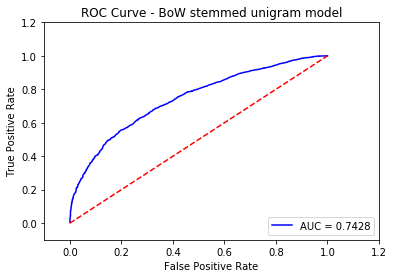

In [32]:
# ROC curve and AUC score

create_ROC_AUC(msr_bow_stem_scores[0], 'BoW stemmed unigram model')

## TF-IDF model

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

def run_tfidf_model(sentences):
    
    '''Creates TF-IDF model and calculates cosine similarity of each sentence pair'''
    
    scores_list = []
    ngrams = [(1, 1), (1, 2)]
    
    for tup in ngrams:
        tfidf_vec = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=tup, 
                                    max_df=1.0, min_df=0.5, max_features=None)
    
        tfidf_scores = []
        for pair in sentences:
            tfidf_model = tfidf_vec.fit_transform(pair).toarray()
            cos_sim = cosine_similarity(tfidf_model[0,:].reshape(1,-1), tfidf_model[1,:].reshape(1, -1))
            tfidf_scores.append(float(cos_sim))
            
        scores_list.append(tfidf_scores)
           
    return scores_list

In [52]:
# Implementation

sick_tfidf_scores = run_tfidf_model(sick_sentences)
msr_tfidf_scores = run_tfidf_model(msr_sentences)

sick_tfidf_stem_scores = run_tfidf_model(sick_sentences_stem)
msr_tfidf_stem_scores = run_tfidf_model(msr_sentences_stem)

sick_tfidf_lem_scores = run_tfidf_model(sick_sentences_lemma)
msr_tfidf_lem_scores = run_tfidf_model(msr_sentences_lemma)

sick_tfidf_stw_scores = run_tfidf_model(sick_filtered)
msr_tfidf_stw_scores = run_tfidf_model(msr_filtered)

In [ ]:
sick_tfidf_scores

In [ ]:
msr_tfidf_scores

In [53]:
df_sick_tfidf = pd.DataFrame({'Relatedness': sick_scores, 'TF-IDF_uni': sick_tfidf_scores[0], 'TF-IDF_bi': sick_tfidf_scores[1],
                            'TF-IDF_stem_uni': sick_tfidf_stem_scores[0], 'TF-IDF_stem_bi': sick_tfidf_stem_scores[1],
                            'TF-IDF_lemma_uni': sick_tfidf_lem_scores[0], 'TF-IDF_lemma_bi': sick_tfidf_lem_scores[1], 
                            'TF-IDF_stw_uni': sick_tfidf_stw_scores[0], 'TF-IDF_stw_bi': sick_tfidf_stw_scores[1]})
df_sick_tfidf

,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
0,4.500,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992
1,3.200,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619
2,4.700,0.304126,0.203006,0.450268,0.338174,0.450268,0.338174,0.450268,0.338174
3,3.600,0.519388,0.487191,0.747407,0.729728,0.519388,0.390186,0.519388,0.390186
4,3.400,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771
5,3.300,0.190874,0.095554,0.190874,0.095554,0.087044,0.045574,0.087044,0.045574
6,3.700,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849
7,3.000,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286
8,3.700,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040
9,4.900,0.867364,0.724107,0.883128,0.758156,0.867364,0.724107,0.867364,0.724107


In [54]:
# Implementation

create_correlation_tables(df_sick_tfidf)

,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
Relatedness,1.000000,0.560429,0.472194,0.588698,0.493539,0.592724,0.494923,0.592746,0.494934
TF-IDF_uni,0.560429,1.000000,0.949001,0.945470,0.932648,0.935472,0.923116,0.935479,0.923121
TF-IDF_bi,0.472194,0.949001,1.000000,0.877722,0.974425,0.868492,0.965412,0.868492,0.965413
TF-IDF_stem_uni,0.588698,0.945470,0.877722,1.000000,0.925765,0.975357,0.903558,0.975363,0.903561
TF-IDF_stem_bi,0.493539,0.932648,0.974425,0.925765,1.000000,0.903386,0.976208,0.903386,0.976209
TF-IDF_lemma_uni,0.592724,0.935472,0.868492,0.975357,0.903386,1.000000,0.923432,0.999999,0.923432
TF-IDF_lemma_bi,0.494923,0.923116,0.965412,0.903558,0.976208,0.923432,1.000000,0.923429,1.000000
TF-IDF_stw_uni,0.592746,0.935479,0.868492,0.975363,0.903386,0.999999,0.923429,1.000000,0.923430
TF-IDF_stw_bi,0.494934,0.923121,0.965413,0.903561,0.976209,0.923432,1.000000,0.923430,1.000000


Pearson's correlation


,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
Relatedness,1.000000,0.558943,0.548133,0.575866,0.559361,0.581774,0.561944,0.581792,0.561968
TF-IDF_uni,0.558943,1.000000,0.975484,0.949951,0.950735,0.942335,0.942905,0.942341,0.942914
TF-IDF_bi,0.548133,0.975484,1.000000,0.917617,0.971182,0.911414,0.964537,0.911417,0.964542
TF-IDF_stem_uni,0.575866,0.949951,0.917617,1.000000,0.960206,0.978559,0.942262,0.978564,0.942269
TF-IDF_stem_bi,0.559361,0.950735,0.971182,0.960206,1.000000,0.943346,0.982808,0.943348,0.982812
TF-IDF_lemma_uni,0.581774,0.942335,0.911414,0.978559,0.943346,1.000000,0.959869,0.999999,0.959870
TF-IDF_lemma_bi,0.561944,0.942905,0.964537,0.942262,0.982808,0.959869,1.000000,0.959866,0.999999
TF-IDF_stw_uni,0.581792,0.942341,0.911417,0.978564,0.943348,0.999999,0.959866,1.000000,0.959869
TF-IDF_stw_bi,0.561968,0.942914,0.964542,0.942269,0.982812,0.959870,0.999999,0.959869,1.000000


Spearman's correlation


In [65]:
# Convert scores to binary

msr_tfidf_binscores, msr_tfidf_stem_binscores, msr_tfidf_lem_binscores, msr_tfidf_stw_binscores = [], [], [], []
threshold = 0.36

for i in range(0, 2):
    msr_tfidf_binscores.append(convert_scores_to_binary(msr_tfidf_scores[i], threshold))
    msr_tfidf_stem_binscores.append(convert_scores_to_binary(msr_tfidf_stem_scores[i], threshold))
    msr_tfidf_lem_binscores.append(convert_scores_to_binary(msr_tfidf_lem_scores[i], threshold))
    msr_tfidf_stw_binscores.append(convert_scores_to_binary(msr_tfidf_stw_scores[i], threshold))

In [66]:
df_msr_tfidf = pd.DataFrame({'Similarity': msr_scores, 'TF-IDF_uni': msr_tfidf_binscores[0], 'TF-IDF_bi': msr_tfidf_binscores[1],
                            'TF-IDF_stem_uni': msr_tfidf_stem_binscores[0], 'TF-IDF_stem_bi': msr_tfidf_stem_binscores[1],
                            'TF-IDF_lemma_uni': msr_tfidf_lem_binscores[0], 'TF-IDF_lemma_bi': msr_tfidf_lem_binscores[1], 
                            'TF-IDF_stw_uni': msr_tfidf_stw_binscores[0], 'TF-IDF_stw_bi': msr_tfidf_stw_binscores[1]})
df_msr_tfidf

,Similarity,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi
0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,1,0,1,0
2,1,1,1,1,1,1,1,1,1
3,0,1,0,1,0,1,0,1,0
4,1,1,0,1,0,1,0,1,0
5,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0
7,1,1,0,1,0,1,0,1,0
8,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1


In [67]:
# Implementation

create_confusion_matrices(df_msr_tfidf)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
TF-IDF_uni,,
True 0,667,1234
True 1,520,3380


Accuracy: 0.697638
F1 score: 0.793986


,Pred 0,Pred 1
TF-IDF_bi,,
True 0,1187,714
True 1,1336,2564


Accuracy: 0.646613
F1 score: 0.714405


,Pred 0,Pred 1
TF-IDF_stem_uni,,
True 0,626,1275
True 1,391,3509


Accuracy: 0.712808
F1 score: 0.808153


,Pred 0,Pred 1
TF-IDF_stem_bi,,
True 0,1111,790
True 1,1183,2717


Accuracy: 0.659886
F1 score: 0.73363


,Pred 0,Pred 1
TF-IDF_lemma_uni,,
True 0,620,1281
True 1,441,3459


Accuracy: 0.703155
F1 score: 0.800694


,Pred 0,Pred 1
TF-IDF_lemma_bi,,
True 0,1140,761
True 1,1241,2659


Accuracy: 0.654887
F1 score: 0.726503


,Pred 0,Pred 1
TF-IDF_stw_uni,,
True 0,618,1283
True 1,438,3462


Accuracy: 0.703327
F1 score: 0.800925


,Pred 0,Pred 1
TF-IDF_stw_bi,,
True 0,1138,763
True 1,1241,2659


Accuracy: 0.654542
F1 score: 0.726304


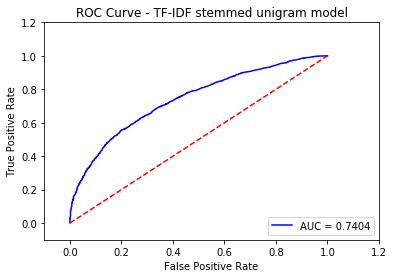

In [58]:
# ROC curve and AUC score

create_ROC_AUC(msr_tfidf_stem_scores[0], 'TF-IDF stemmed unigram model')

## Functions for model execution

In [68]:
def create_words_list(sentences):
    
    '''Creates a list with separate words in each sentence'''
    
    words_list = []

    for pair in sentences:
        pair_new = []
        for sent in pair:
            words = sent.split()
            pair_new.append(words)

        words_list.append(pair_new)
    
    return words_list

In [69]:
# Implementation

sick_words_list = create_words_list(sick_filtered)
msr_words_list = create_words_list(msr_filtered)

In [ ]:
sick_words_list

In [ ]:
msr_words_list

In [70]:
def run_gensim_model(words_list, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model[word])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [71]:
def run_spacy_model(sentences, model):
    
    '''Runs Word2Vec and GloVe models in SpaCy and computes cosine similarity scores for each sentence pair'''
    
    scores = []
    for pair in sentences:
        token1 = model(pair[0])
        token2 = model(pair[1])
        scores.append(token1.similarity(token2))

    return scores

In [72]:
from glove import Corpus, Glove

def run_glove_model(words_list, model):
    
    '''Runs GloVe model in glove and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model.word_vectors[model.dictionary[word]])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [73]:
def run_sent2vec_model(sentences, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in sentences:
        embeddings_list = []
        for sent in pair:
            try:
                embeddings_list.append(model.embed_sentence(sent))
            except:
                embeddings_list.append(np.array(0))
                
        cos_sim = cosine_similarity(embeddings_list[0].reshape(1, -1), embeddings_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

## Word2Vec

In [74]:
# Load Google's pre-trained Word2Vec model

modelwd_pret = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [ ]:
modelwd_pret['dog']

In [ ]:
modelwd_pret.most_similar(positive=['yes', 'yeah'])

In [ ]:
modelwd_pret.similarity('good', 'great')

In [75]:
# Implementation

sick_wdpret_scores = run_gensim_model(sick_words_list, modelwd_pret)
msr_wdpret_scores = run_gensim_model(msr_words_list, modelwd_pret)

In [ ]:
sick_wdpret_scores

In [ ]:
msr_wdpret_scores

In [77]:
modelwd_spacy = spacy.load("en", vectors="GoogleNews-vectors-negative300.bin")

In [78]:
# Implementation

sick_wdspacy_scores = run_spacy_model(sick_filtered, modelwd_spacy)
msr_wdspacy_scores = run_spacy_model(msr_filtered, modelwd_spacy)

In [ ]:
sick_wdspacy_scores

In [ ]:
msr_wdspacy_scores

In [79]:
# Load trained word2vec CBOW and Skip-Gram models

modelwd_cbow = KeyedVectors.load_word2vec_format('modelwd_cbow.bin', binary=True)
modelwd_sg = KeyedVectors.load_word2vec_format('modelwd_sg.bin', binary=True)  

In [ ]:
modelwd_cbow.wv.most_similar(positive='good', negative='bad')

In [ ]:
modelwd_cbow.wv.similarity('person', 'people')

In [80]:
# Implementation

sick_wdcbow_scores = run_gensim_model(sick_words_list, modelwd_cbow)
msr_wdcbow_scores = run_gensim_model(msr_words_list, modelwd_cbow)

sick_wdsg_scores = run_gensim_model(sick_words_list, modelwd_sg)
msr_wdsg_scores = run_gensim_model(msr_words_list, modelwd_sg)

In [ ]:
sick_wdcbow_scores

In [ ]:
msr_wdsg_scores

In [81]:
df_sick_w2v = pd.DataFrame({'Relatedness': sick_scores, 'Word2Vec_pret': sick_wdpret_scores,
                            'Word2Vec_cbow': sick_wdcbow_scores, 'Word2Vec_sg': sick_wdsg_scores})
df_sick_w2v

,Relatedness,Word2Vec_pret,Word2Vec_cbow,Word2Vec_sg
0,4.500,0.963674,0.936647,0.951577
1,3.200,0.830682,0.840805,0.870387
2,4.700,0.921303,0.909995,0.931410
3,3.600,0.939009,0.919940,0.936252
4,3.400,0.734106,0.746335,0.747096
5,3.300,0.707422,0.718379,0.699687
6,3.700,0.725023,0.755996,0.752587
7,3.000,0.661670,0.662835,0.680367
8,3.700,0.744693,0.734949,0.730587
9,4.900,0.970822,0.972881,0.968408


In [82]:
# Implementation

create_correlation_tables(df_sick_w2v)

,Relatedness,Word2Vec_pret,Word2Vec_cbow,Word2Vec_sg
Relatedness,1.000000,0.710151,0.619914,0.696689
Word2Vec_pret,0.710151,1.000000,0.930165,0.985541
Word2Vec_cbow,0.619914,0.930165,1.000000,0.948410
Word2Vec_sg,0.696689,0.985541,0.948410,1.000000


Pearson's correlation


,Relatedness,Word2Vec_pret,Word2Vec_cbow,Word2Vec_sg
Relatedness,1.000000,0.590669,0.548781,0.587305
Word2Vec_pret,0.590669,1.000000,0.947425,0.984737
Word2Vec_cbow,0.548781,0.947425,1.000000,0.960490
Word2Vec_sg,0.587305,0.984737,0.960490,1.000000


Spearman's correlation


In [141]:
# Convert scores to binary

msr_wdpret_binscores = convert_scores_to_binary(msr_wdpret_scores, 0.75)
#msr_wdspacy_binscores = convert_scores_to_binary(msr_wdspacy_scores, 0.7)
msr_wdcbow_binscores = convert_scores_to_binary(msr_wdcbow_scores, 0.75)
msr_wdsg_binscores = convert_scores_to_binary(msr_wdsg_scores, 0.86)

In [142]:
df_msr_w2v = pd.DataFrame({'Similarity': msr_scores, 'Word2Vec_pret_0.75': msr_wdpret_binscores, 
                           'Word2Vec_cbow_0.75': msr_wdcbow_binscores, 'Word2Vec_sg_0.86': msr_wdsg_binscores})
df_msr_w2v

,Similarity,Word2Vec_pret_0.75,Word2Vec_cbow_0.75,Word2Vec_sg_0.86
0,1,1,1,1
1,0,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,1,1,1
5,1,1,1,1
6,0,0,1,0
7,1,1,1,0
8,0,0,1,0
9,1,1,1,1


In [143]:
# Implementation

create_confusion_matrices(df_msr_w2v)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
Word2Vec_pret_0.75,,
True 0,436,1465
True 1,243,3657


Accuracy: 0.705568
F1 score: 0.810685


,Pred 0,Pred 1
Word2Vec_cbow_0.75,,
True 0,570,1331
True 1,474,3426


Accuracy: 0.688847
F1 score: 0.791498


,Pred 0,Pred 1
Word2Vec_sg_0.86,,
True 0,747,1154
True 1,562,3338


Accuracy: 0.704189
F1 score: 0.79552


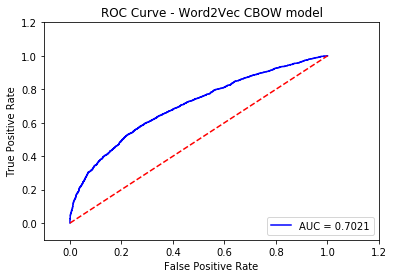

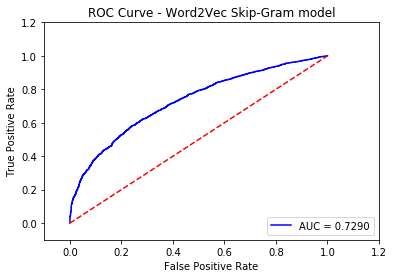

In [86]:
# ROC curve and AUC score for Skip-Gram and CBOW models

create_ROC_AUC(msr_wdcbow_scores, 'Word2Vec CBOW model')
create_ROC_AUC(msr_wdsg_scores, 'Word2Vec Skip-Gram model')

## GloVe

In [144]:
# Load pretrained corpus of GloVe vectors

#glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")

modelgl_pret = KeyedVectors.load_word2vec_format('gensim_glove_vectors.txt', binary=False)  

In [145]:
# Implementation

sick_glpret_scores = run_gensim_model(sick_words_list, modelgl_pret)
msr_glpret_scores = run_gensim_model(msr_words_list, modelgl_pret)

In [ ]:
sick_glpret_scores

In [ ]:
msr_glpret_scores

In [ ]:
#modelgl_spacy = spacy.load("en_vectors_web_lg")

In [146]:
modelgl_spacy = spacy.load("en", vectors="glove.6B.300d.txt")

In [147]:
# Implementation

sick_glspacy_scores = run_spacy_model(sick_filtered, modelgl_spacy)
msr_glspacy_scores = run_spacy_model(msr_filtered, modelgl_spacy)

In [ ]:
sick_glspacy_scores

In [ ]:
msr_glspacy_scores

In [148]:
# Load trained GloVe model using demo.sh

#glove2word2vec(glove_input_file="/project/GloVe/modelgl_train.txt", word2vec_output_file="modelgl_vectors.txt")

# Load pretrained corpus of GloVe vectors
modelgl_train = KeyedVectors.load_word2vec_format('modelgl_vectors.txt', binary=False)  

In [ ]:
modelgl_train.most_similar('frog')

In [ ]:
modelgl_train.word_vectors[modelgl_train.dictionary['frog']]

In [149]:
# Implementation

sick_gltrain_scores = run_gensim_model(sick_words_list, modelgl_train)
msr_gltrain_scores = run_gensim_model(msr_words_list, modelgl_train)

In [ ]:
sick_gltrain_scores

In [ ]:
msr_gltrain_scores

In [150]:
df_sick_glv = pd.DataFrame({'Relatedness': sick_scores, 'GloVe_pret': sick_glpret_scores, 'GloVe_train': sick_gltrain_scores})
df_sick_glv

,Relatedness,GloVe_pret,GloVe_train
0,4.500,0.967390,0.969096
1,3.200,0.904996,0.938729
2,4.700,0.936549,0.930987
3,3.600,0.944773,0.945433
4,3.400,0.803470,0.845976
5,3.300,0.770339,0.787942
6,3.700,0.823388,0.868506
7,3.000,0.773037,0.840032
8,3.700,0.823194,0.842586
9,4.900,0.974747,0.980663


In [151]:
# Implementation

create_correlation_tables(df_sick_glv)

,Relatedness,GloVe_pret,GloVe_train
Relatedness,1.000000,0.689832,0.639904
GloVe_pret,0.689832,1.000000,0.962146
GloVe_train,0.639904,0.962146,1.000000


Pearson's correlation


,Relatedness,GloVe_pret,GloVe_train
Relatedness,1.000000,0.578059,0.553012
GloVe_pret,0.578059,1.000000,0.967742
GloVe_train,0.553012,0.967742,1.000000


Spearman's correlation


In [192]:
# Convert scores to binary

msr_glpret_binscores = convert_scores_to_binary(msr_glpret_scores, 0.83)
#msr_glspacy_binscores = convert_scores_to_binary(msr_glspacy_scores, 0.7)
msr_gltrain_binscores = convert_scores_to_binary(msr_gltrain_scores, 0.89)

In [195]:
df_msr_glv = pd.DataFrame({'Similarity': msr_scores, 'GloVe_pret_0.83': msr_glpret_binscores, 'GloVe_train_0.89': msr_gltrain_binscores})
df_msr_glv

,Similarity,GloVe_pret_0.83,GloVe_train_0.89
0,1,1,1
1,0,1,1
2,1,1,1
3,0,1,1
4,1,1,1
5,1,1,1
6,0,0,0
7,1,1,1
8,0,0,0
9,1,1,1


In [196]:
# Implementation

create_confusion_matrices(df_msr_glv)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
GloVe_pret_0.83,,
True 0,482,1419
True 1,291,3609


Accuracy: 0.705223
F1 score: 0.808468


,Pred 0,Pred 1
GloVe_train_0.89,,
True 0,765,1136
True 1,618,3282


Accuracy: 0.697638
F1 score: 0.789132


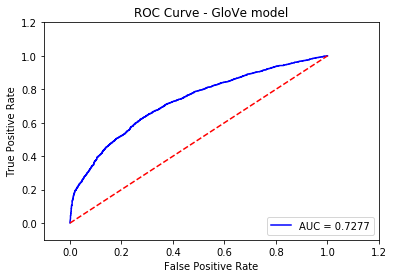

In [197]:
# ROC curve and AUC score for GloVe model

create_ROC_AUC(msr_gltrain_scores, 'GloVe model')

## fastText

In [198]:
# Load trained CBOW and Skip-Gram models

modelft_cbow = FastText.load_fasttext_format('/project/fastText/modelft_cbow.bin')
modelft_sg = FastText.load_fasttext_format('/project/fastText/modelft_sg.bin')

In [ ]:
modelft_cbow.most_similar('teacher')

In [ ]:
modelft_sg.similarity('teacher', 'lecturer')

In [199]:
# Implementation

sick_ftsg_scores = run_gensim_model(sick_words_list, modelft_sg)
sick_ftcbow_scores = run_gensim_model(sick_words_list, modelft_cbow)

msr_ftsg_scores = run_gensim_model(msr_words_list, modelft_sg)
msr_ftcbow_scores = run_gensim_model(msr_words_list, modelft_cbow)

In [ ]:
sick_ftcbow_scores

In [ ]:
msr_ftsg_scores

In [200]:
df_sick_ft = pd.DataFrame({'Relatedness': sick_scores, 'fastText_cbow': sick_ftcbow_scores, 'fastText_sg': sick_ftsg_scores})
df_sick_ft

,Relatedness,fastText_cbow,fastText_sg
0,4.500,0.923365,0.962844
1,3.200,0.864714,0.903546
2,4.700,0.930503,0.941339
3,3.600,0.969844,0.954547
4,3.400,0.843352,0.828923
5,3.300,0.824850,0.794268
6,3.700,0.908704,0.833720
7,3.000,0.831956,0.787185
8,3.700,0.857678,0.821788
9,4.900,0.987234,0.981121


In [201]:
# Implementation

create_correlation_tables(df_sick_ft)

,Relatedness,fastText_cbow,fastText_sg
Relatedness,1.000000,0.627300,0.707734
fastText_cbow,0.627300,1.000000,0.912041
fastText_sg,0.707734,0.912041,1.000000


Pearson's correlation


,Relatedness,fastText_cbow,fastText_sg
Relatedness,1.000000,0.541683,0.589372
fastText_cbow,0.541683,1.000000,0.933727
fastText_sg,0.589372,0.933727,1.000000


Spearman's correlation


In [230]:
# Convert scores to binary

msr_ftcbow_binscores = convert_scores_to_binary(msr_ftcbow_scores, 0.85)
msr_ftsg_binscores = convert_scores_to_binary(msr_ftsg_scores, 0.89)

In [233]:
df_msr_ft = pd.DataFrame({'Similarity': msr_scores, 'fastText_cbow_0.85': msr_ftcbow_binscores, 'fastText_sg_0.89': msr_ftsg_binscores})
df_msr_ft

,Similarity,fastText_cbow_0.85,fastText_sg_0.89
0,1,1,1
1,0,1,1
2,1,1,1
3,0,1,1
4,1,1,1
5,1,1,1
6,0,0,0
7,1,0,1
8,0,0,0
9,1,1,1


In [234]:
# Implementation

create_confusion_matrices(df_msr_ft)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
fastText_cbow_0.85,,
True 0,628,1273
True 1,447,3453


Accuracy: 0.703499
F1 score: 0.800603


,Pred 0,Pred 1
fastText_sg_0.89,,
True 0,756,1145
True 1,551,3349


Accuracy: 0.707637
F1 score: 0.797951


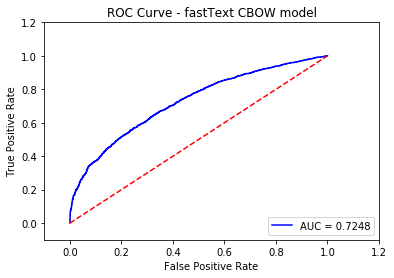

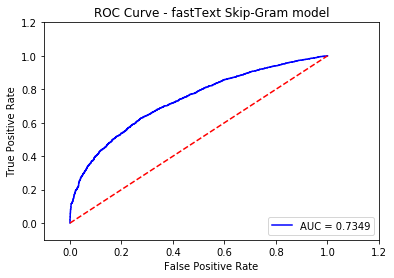

In [235]:
# ROC curve and AUC score for Skip-Gram and CBOW models

create_ROC_AUC(msr_ftcbow_scores, 'fastText CBOW model')
create_ROC_AUC(msr_ftsg_scores, 'fastText Skip-Gram model')

## Sent2Vec

In [606]:
# Load model with character bigrams

#modelsn_newbi = sent2vec.Sent2vecModel()
#modelsn_newbi.load_model('/project/sent2vec/modelsn_newbi.bin')

#sick_snnewbi_scores = run_sent2vec_model(sick_filtered, modelsn_newbi)
#msr_snnewbi_scores = run_sent2vec_model(msr_filtered, modelsn_newbi)

In [681]:
#modelsn_newuni = sent2vec.Sent2vecModel()
#modelsn_newuni.load_model('/project/sent2vec/modelsn_newuni.bin')

#sick_snnewuni_scores = run_sent2vec_model(sick_filtered, modelsn_newuni)
#msr_snnewuni_scores = run_sent2vec_model(msr_filtered, modelsn_newuni)

In [236]:
# Load model with character bigrams

modelsn_uni = sent2vec.Sent2vecModel()
modelsn_uni.load_model('/project/sent2vec/modelsn_uni.bin')

In [237]:
# Load model with character bigrams

modelsn_bi = sent2vec.Sent2vecModel()
modelsn_bi.load_model('/project/sent2vec/modelsn_bi.bin')

In [238]:
# Implementation

sick_snuni_scores = run_sent2vec_model(sick_filtered, modelsn_uni)
msr_snuni_scores = run_sent2vec_model(msr_filtered, modelsn_uni)

sick_snbi_scores = run_sent2vec_model(sick_filtered, modelsn_bi)
msr_snbi_scores = run_sent2vec_model(msr_filtered, modelsn_bi)

In [ ]:
sick_snuni_scores

In [ ]:
msr_snbi_scores

In [239]:
df_sick_s2v = pd.DataFrame({'Relatedness': sick_scores, 'sent2vec_uni': sick_snuni_scores, 'sent2vec_bi': sick_snbi_scores})
df_sick_s2v

,Relatedness,sent2vec_uni,sent2vec_bi
0,4.500,0.939582,0.931216
1,3.200,0.853982,0.828374
2,4.700,0.923340,0.915496
3,3.600,0.927023,0.927919
4,3.400,0.652154,0.676675
5,3.300,0.616929,0.614791
6,3.700,0.684801,0.676276
7,3.000,0.636579,0.611435
8,3.700,0.645401,0.634606
9,4.900,0.960235,0.948559


In [240]:
# Implementation

create_correlation_tables(df_sick_s2v)

,Relatedness,sent2vec_uni,sent2vec_bi
Relatedness,1.000000,0.692696,0.701375
sent2vec_uni,0.692696,1.000000,0.979565
sent2vec_bi,0.701375,0.979565,1.000000


Pearson's correlation


,Relatedness,sent2vec_uni,sent2vec_bi
Relatedness,1.000000,0.593495,0.586798
sent2vec_uni,0.593495,1.000000,0.979434
sent2vec_bi,0.586798,0.979434,1.000000


Spearman's correlation


In [278]:
# Convert scores to binary

msr_snuni_binscores = convert_scores_to_binary(msr_snuni_scores, 0.73)
msr_snbi_binscores = convert_scores_to_binary(msr_snbi_scores, 0.66)
#msr_snnewbi_binscores = convert_scores_to_binary(msr_snnewbi_scores, 0.7)
#msr_snnewuni_binscores = convert_scores_to_binary(msr_snnewuni_scores, 0.7)

In [279]:
df_msr_s2v = pd.DataFrame({'Similarity': msr_scores, 'sent2vec_uni_0.73': msr_snuni_binscores, 'sent2vec_bi_0.66': msr_snbi_binscores})
df_msr_s2v

,Similarity,sent2vec_uni_0.73,sent2vec_bi_0.66
0,1,1,1
1,0,1,1
2,1,1,1
3,0,1,1
4,1,1,1
5,1,1,1
6,0,0,0
7,1,1,1
8,0,0,0
9,1,1,1


In [280]:
# Implementation

create_confusion_matrices(df_msr_s2v)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
sent2vec_uni_0.73,,
True 0,701,1200
True 1,505,3395


Accuracy: 0.706085
F1 score: 0.799294


,Pred 0,Pred 1
sent2vec_bi_0.66,,
True 0,296,1605
True 1,167,3733


Accuracy: 0.694535
F1 score: 0.808184


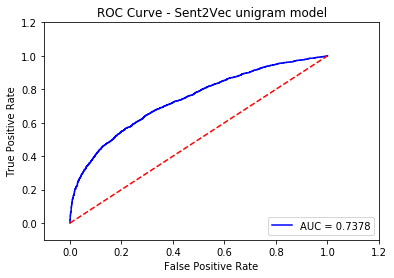

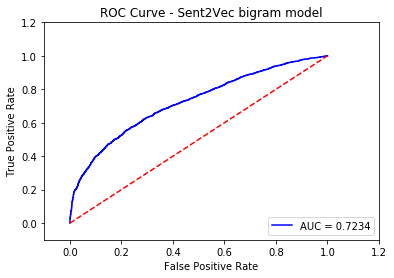

In [281]:
# ROC curve and AUC score for sent2vec models

create_ROC_AUC(msr_snuni_scores, 'Sent2Vec unigram model')
create_ROC_AUC(msr_snbi_scores, 'Sent2Vec bigram model')

## Doc2Vec (don't implement)

In [29]:
def create_docs_list(sentences):
    
    '''Creates a list of sentences corresponding to a document'''
    
    docs_list = []
    for pair in sentences:
        docs_list.append(pair[0])
        docs_list.append(pair[1])
        
    return docs_list

In [30]:
def create_tagged_documents(sentences):
    
    '''Gives numerical tags to documents in a list'''
    
    docs_list = create_docs_list(sentences)
    
    tagged_docs = []
    for i, doc in enumerate(docs_list):
        tagged_docs.append(TaggedDocument(words=doc.split(), tags=[i]))
    
    return docs_list, tagged_docs

In [ ]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for i, line in enumerate(open(os.path.join(self.dirname, fname))):
                yield TaggedDocument(words=line.split(), tags=[i])

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])

In [ ]:
# Assign documents to directory of dataset for training

tagged_docs = MyDocuments("/project/sample-billwords")

In [ ]:
# Assign documents to directory of dataset for training

tagged_docs = LabeledLineSentence("/project/sample-billwords/billwords_sample.txt")

In [ ]:
modeldc_dm = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=100, alpha=0.025, min_alpha=0.025, 
                     negative=5, dm=1, dbow_words=0)

In [ ]:
def train_doc2vec_model(tagged_docs, dm, dbow_words):
    
    '''Train a different Doc2Vec model using specific parameters'''
    
    model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=100, alpha=0.025, min_alpha=0.025, 
                     negative=5, dm=dm, dbow_words=dbow_words)
    
    return model

In [ ]:
# Implementation

modeldc_dm = train_doc2vec_model(tagged_docs, dm=1, dbow_words=0)
print('completed')
modeldc_dbow0 = train_doc2vec_model(tagged_docs, dm=0, dbow_words=0)
print('completed')
modeldc_dbow1 = train_doc2vec_model(tagged_docs, dm=0, dbow_words=1)
print('completed')

In [ ]:
modeldc_dm.save('modeldc_dm.doc2vec')
modeldc_dbow0.save('modeldc_dbow0.doc2vec')
modeldc_dbow1.save('modeldc_dbow1.doc2vec')

In [ ]:
modeldc_dm = Doc2Vec.load('modeldc_dm.doc2vec')

In [ ]:
modeldc_dbow1.most_similar('kid')

In [ ]:
modeldc_dm.infer_vector(sick_docs_list[0])

In [ ]:
sick_docs_list, sick_tagged_docs = create_tagged_documents(sick_filtered)
msr_docs_list, msr_tagged_docs = create_tagged_documents(msr_filtered)

In [ ]:
sick_tagged_docs

In [ ]:
msr_tagged_docs

In [ ]:
def run_doc2vec_model(docs_list, model):
    
    '''Runs Doc2Vec models and computes cosine similarity scores for each sentence (document) pair'''
    
    scores = []

    i = 0
    while i < len(docs_list):

        vector1 = model.infer_vector(docs_list[i])
        vector2 = model.infer_vector(docs_list[i+1])
        
        cos_sim = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))
        #cos_sim = dot(vector1.T, vector2)/(linalg.norm(vector1)*linalg.norm(vector2))
        #print(cos_sim)
        scores.append(float(cos_sim))
        i += 2
        
    return scores

In [ ]:
# Implementation

sick_dcdm_scores = run_doc2vec_model(sick_docs_list, modeldc_dm)
sick_dcdbow0_scores = run_doc2vec_model(sick_docs_list, modeldc_dbow0)
sick_dcdbow1_scores = run_doc2vec_model(sick_docs_list, modeldc_dbow1)

msr_dcdm_scores = run_doc2vec_model(msr_docs_list, modeldc_dm)
msr_dcdbow0_scores = run_doc2vec_model(msr_docs_list, modeldc_dbow0)
msr_dcdbow1_scores = run_doc2vec_model(msr_docs_list, modeldc_dbow1)

In [ ]:
# Convert scores to binary

msr_dcdm_binscores = convert_scores_to_binary(msr_dcdm_scores, 0.7)
msr_dcdbow0_binscores = convert_scores_to_binary(msr_dcdbow0_scores, 0.7)
msr_dcdbow1_binscores = convert_scores_to_binary(msr_dcdbow1_scores, 0.7)

In [ ]:
model = Doc2Vec.load("model")

In [ ]:
df_sick_d2v = pd.DataFrame({'Relatedness': sick_scores, 'Doc2Vec_dm': sick_dcdm_scores, 'Doc2Vec_dbow0': sick_dcdbow0_scores,
                              'Doc2Vec_dbow1': sick_dcdbow1_scores})
df_sick_d2v

In [ ]:
df_sick_d2v.corr(method='pearson')

In [ ]:
df_sick_d2v.corr(method='spearman')

In [ ]:
df_msr_d2v = pd.DataFrame({'Similarity': msr_scores, 'Doc2Vec_dm': msr_dcdm_binscores, 'Doc2Vec_dbow0': msr_dcdbow0_binscores,
                              'Doc2Vec_dbow1': msr_dcdbow1_binscores})
df_msr_d2v

In [ ]:
# Confusion matrix of Doc2Vec scores

#plt.figure(figsize=(6, 4))

msr_dcdm_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dm']),  
                      columns=['D2V_dm 0', 'D2V_dm 1'], index=['MSR 0', 'MSR 1'])

msr_dcdbow0_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dbow0']),  
                      columns=['D2V_dbow0 0', 'D2V_dbow0 1'], index=['MSR 0', 'MSR 1'])

msr_dcdbow1_cf = pd.DataFrame(confusion_matrix(df_msr_d2v['Similarity'], df_msr_d2v['Doc2Vec_dbow1']),  
                      columns=['D2V_dbow1 0', 'D2V_dbow1 1'], index=['MSR 0', 'MSR 1'])

#sns.heatmap(msr_dcdm_cf, annot=True, cmap='Blues')
#plt.show()
print(msr_dcdm_cf, '\n')
print(msr_dcdbow0_cf, '\n')
print(msr_dcdbow1_cf, '\n')

## Score Comparisons

In [600]:
# Compare scores from pre-trained Word2Vec and GloVe vectors

df_sick_gensim = pd.DataFrame({'Relatedness': sick_scores, 'Word2Vec_pret': sick_wdpret_scores, 'GloVe_pret': sick_glpret_scores})

get_first_row(df_sick_gensim)

,Pearson,Spearman
Correlation,,
Word2Vec_pret,0.710151,0.590669
GloVe_pret,0.689832,0.578059


In [601]:
# Compare scores from pre-trained Word2Vec and GloVe vectors

df_msr_gensim = pd.DataFrame({'Similarity': msr_scores, 'Word2Vec_pret_0.75': msr_wdpret_binscores, 'GloVe_pret_0.85': msr_glpret_binscores})

show_class_scores(df_msr_gensim)

,Accuracy,F1 score
Classification,,
Word2Vec_pret_0.75,0.705568,0.810685
GloVe_pret_0.85,0.703672,0.800880


In [519]:
# Compare best scores using trained vectors from 1 billion words dataset
df_sick_bill = pd.DataFrame({'Relatedness': sick_scores, 'BoW_stw_uni': sick_bow_stw_scores[0], 'TF-IDF_stw_uni': sick_tfidf_stw_scores[0],
                             'Word2Vec_cbow': sick_wdcbow_scores, 'Word2Vec_sg': sick_wdsg_scores, 'GloVe_train': sick_gltrain_scores, 
                             'fastText_cbow': sick_ftcbow_scores, 'fastText_sg': sick_ftsg_scores,
                             'Sent2Vec_uni': sick_snuni_scores, 'Sent2Vec_bi': sick_snbi_scores})

get_first_row(df_sick_bill)

,Pearson,Spearman
Correlation,,
BoW_stw_uni,0.640185,0.581319
TF-IDF_stw_uni,0.592746,0.581792
Word2Vec_cbow,0.619914,0.548781
Word2Vec_sg,0.696689,0.587305
GloVe_train,0.639904,0.553012
fastText_cbow,0.627300,0.541683
fastText_sg,0.707734,0.589372
Sent2Vec_uni,0.692696,0.593495
Sent2Vec_bi,0.701375,0.586798


In [531]:
# Compare best scores using trained vectors from 1 billion words dataset

df_msr_bill = pd.DataFrame({'Similarity': msr_scores, 'BoW_stem_uni_0.55': msr_bow_stem_binscores[0], 'TF-IDF_stem_uni_0.35': msr_tfidf_stem_binscores[0],
                            'Word2Vec_cbow_0.75': msr_wdcbow_binscores, 'Word2Vec_sg_0.8': msr_wdsg_binscores, 
                            'GloVe_train_0.9': msr_gltrain_binscores, 'fastText_cbow_0.85': msr_ftcbow_binscores, 'fastText_sg_0.9': msr_ftsg_binscores,
                            'Sent2Vec_uni_0.75': msr_snuni_binscores, 'Sent2Vec_bi_0.65': msr_snbi_binscores})

show_class_scores(df_msr_bill)

,Accuracy,F1 score
Classification,,
BoW_stem_uni_0.55,0.708154,0.798812
TF-IDF_stem_uni_0.35,0.709360,0.807270
Word2Vec_cbow_0.75,0.688847,0.791498
Word2Vec_sg_0.8,0.686261,0.805597
GloVe_train_0.9,0.697121,0.781820
fastText_cbow_0.85,0.703499,0.800603
fastText_sg_0.9,0.700224,0.786390
Sent2Vec_uni_0.75,0.701776,0.790049
Sent2Vec_bi_0.65,0.692812,0.808222


## Model Visualizations

In [631]:
# Build matrix with 10000 words selected from the vocabulary

count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in modelwd_pret.vocab:
    word_vectors_matrix[i] = modelwd_pret[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 300)


In [632]:
# Compress the word vectors into 2D space

tsne = TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [646]:
# Build dataframe containing the selected words and the x and y coordinates of each word

points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head(10)

Points DataFrame built


,word,x,y
0,</s>,-4.506876,-6.983848
1,in,-3.082289,-2.733579
2,for,-5.162240,-5.386980
3,that,-10.003477,-8.366405
4,is,-43.073048,9.027002
5,on,-3.059551,-1.339653
6,##,4.240963,32.402630
7,The,-57.335941,41.850712
8,with,-3.859573,-3.877647
9,said,-59.609005,14.468599


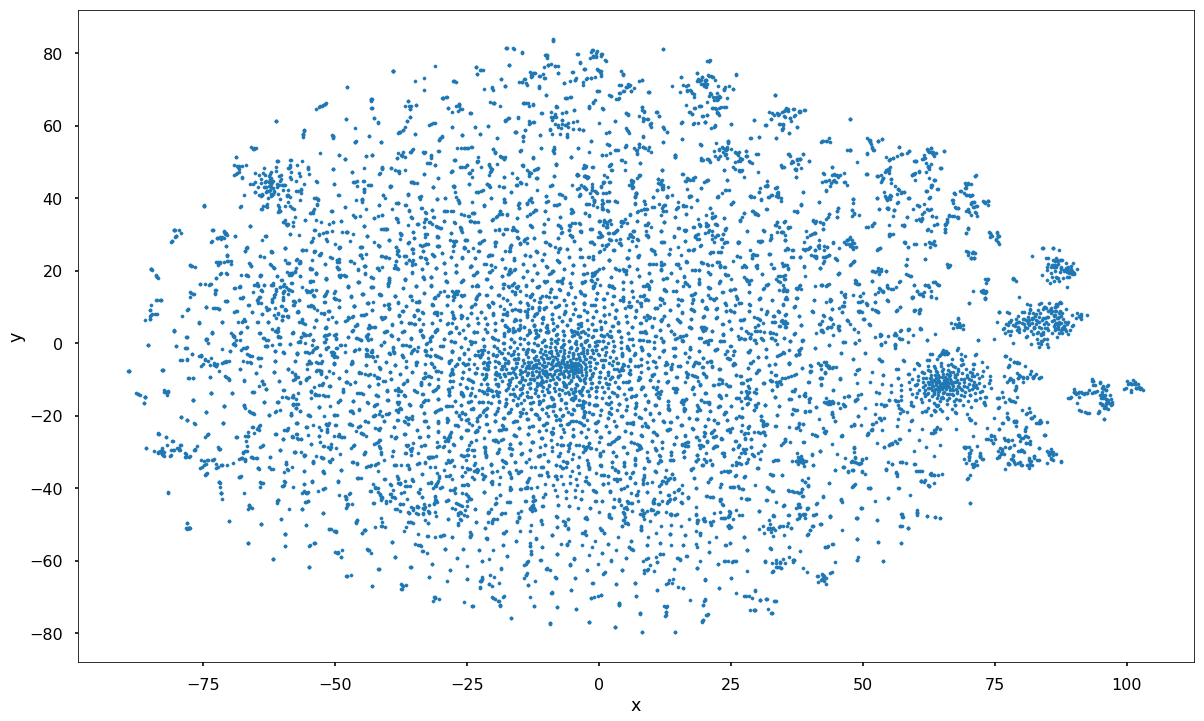

In [637]:
# Plot word vectors on 2D graph

sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.show()

In [651]:
def plot_region(x_bounds, y_bounds):
    
    '''Zooms into a region to see similarity of different words'''
    
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
     
    ax = slice.plot.scatter('x', 'y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

    return

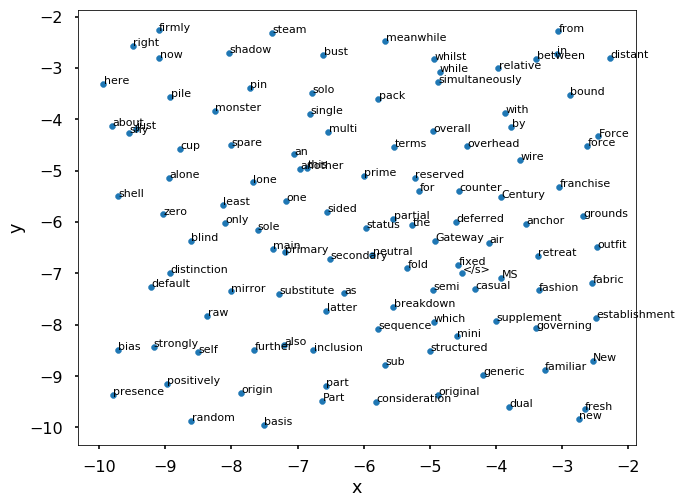

In [652]:
plot_region(x_bounds=(-10, -2), y_bounds=(-10, -2))

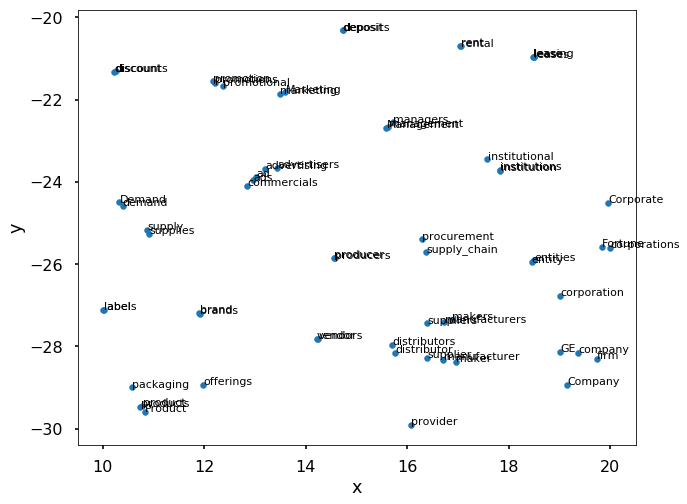

In [670]:
plot_region(x_bounds=(10, 20), y_bounds=(-30, -20))

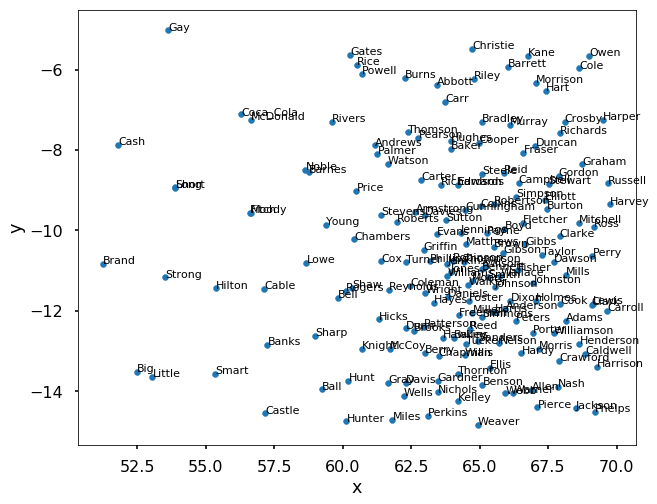

In [676]:
plot_region(x_bounds=(50, 70), y_bounds=(-15, -5))

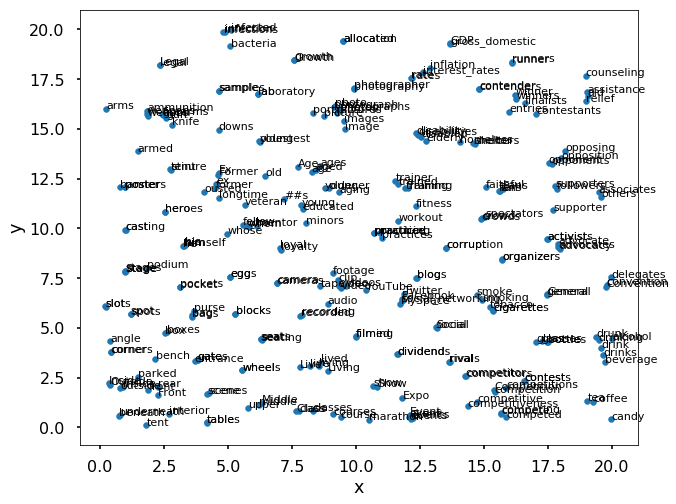

In [680]:
plot_region(x_bounds=(0, 20), y_bounds=(0, 20))